## Imports 

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import os
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.preprocessing import LabelEncoder, PolynomialFeatures, MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn.metrics import roc_auc_score
import warnings
warnings.filterwarnings('ignore')

## Read in data

In [3]:
# list data files available
print(os.listdir("./data/"))

['application_test.csv', 'application_train.csv', 'bureau.csv', 'bureau_balance.csv', 'credit_card_balance.csv', 'HomeCredit_columns_description.csv', 'installments_payments.csv', 'POS_CASH_balance.csv', 'previous_application.csv', 'sample_submission.csv', 'splits']


In [4]:
# training data
df = pd.read_csv('./data/application_train.csv')
print('The shape of training data: ', df.shape)
df.head(3)

The shape of training data:  (307511, 122)


,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


## Exploratory Data Analysis 

The goal of EDA is to learn what the data can tell us. EDA is the process that we calculate statistics and make figures to find trends, anomalies, patterns, or relationships within the data.

### Examine the Distribution of the Target Column

In [5]:
df['TARGET'].value_counts()

0    282686
1     24825
Name: TARGET, dtype: int64

<AxesSubplot:>

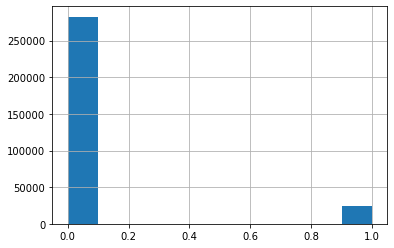

In [6]:
df['TARGET'].hist()

### Imbalance data!!! StratifiedKFold will used in train test split.

From the histgram, we see this is an imbalanced class problem. There are far more loans that were repaid on time than loans that were not repaid. 

### Examine missing values 

In [7]:
df_hasnull = pd.DataFrame(df.isnull().sum()[df.isnull().sum() != 0]).rename(columns={0:'Missing Values'})

In [8]:
print('There are {} columns have missing values among {} columns'.format(len(df_hasnull), df.shape[1]))

There are 67 columns have missing values among 122 columns


In [9]:
df_hasnull['% of Total Values'] = round(df_hasnull['Missing Values']/len(df),3)*100

In [10]:
df_hasnull[df_hasnull['% of Total Values'] > 50].sort_values('% of Total Values', ascending=False)

,Missing Values,% of Total Values
COMMONAREA_AVG,214865,69.9
COMMONAREA_MEDI,214865,69.9
COMMONAREA_MODE,214865,69.9
NONLIVINGAPARTMENTS_MEDI,213514,69.4
NONLIVINGAPARTMENTS_AVG,213514,69.4
NONLIVINGAPARTMENTS_MODE,213514,69.4
FONDKAPREMONT_MODE,210295,68.4
LIVINGAPARTMENTS_MEDI,210199,68.4
LIVINGAPARTMENTS_AVG,210199,68.4
LIVINGAPARTMENTS_MODE,210199,68.4


### Anormalies

In [11]:
(df['DAYS_EMPLOYED']/-365).describe()

count    307511.000000
mean       -174.835742
std         387.056895
min       -1000.665753
25%           0.791781
50%           3.323288
75%           7.561644
max          49.073973
Name: DAYS_EMPLOYED, dtype: float64

The minimum days of employment is -1000 year, which doesn't seem to be right. 

<AxesSubplot:>

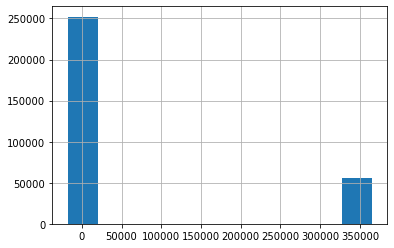

In [12]:
df['DAYS_EMPLOYED'].hist()

In [13]:
df['DAYS_EMPLOYED'].sort_values(ascending=False).head(10)

146327    365243
229266    365243
157475    365243
229294    365243
157480    365243
80598     365243
229285    365243
80597     365243
157481    365243
229277    365243
Name: DAYS_EMPLOYED, dtype: int64

Those anomal days of employment seems to be the same number 365243, and there are more than 50000 client having this number.
So do these anomalies bring difference to the target we are going to predict? 

In [14]:
non_anomal = df[df['DAYS_EMPLOYED'] < 365243]['TARGET'].mean() *100
anomal = df[df['DAYS_EMPLOYED'] == 365243]['TARGET'].mean() *100
print('The non-anomalies default on {:.2f} of loans'.format(non_anomal))
print('The anomalies default on {:.2f} of loans'.format(anomal))

The non-anomalies default on 8.66 of loans
The anomalies default on 5.40 of loans


Looks like the anomalies have a lower rate of default.

As a solution, we will fill in the anomalous values with not a number (np.nan) and then create a new boolean column indicating whether or not the value was anomalous.

In [15]:
# create an anomalous flag column
df['DAYS_EMPLOYED_ANOM'] = df["DAYS_EMPLOYED"] == 365243

# replace the anomalous values with nan
df['DAYS_EMPLOYED'].replace({365243: np.nan}, inplace = True)

### Train Test split

In [16]:
skf = StratifiedKFold(n_splits=3)
 
fold_no = 1
for train_index, test_index in skf.split(df, df['TARGET']):
    train = df.loc[train_index,:]
    test = df.loc[test_index,:]
    train_filename = 'train_split_' + str(fold_no) + '.csv'
    test_filename = 'test_split_' + str(fold_no) + '.csv'
    train.to_csv('data/splits/' + train_filename, index=False)
    test.to_csv('data/splits/' + test_filename, index=False)
    print('Fold',str(fold_no),'Class Ratio:',sum(test['TARGET'])/len(test['TARGET']))
    fold_no += 1

Fold 1 Class Ratio: 0.08072855693436354
Fold 2 Class Ratio: 0.08072855693436354
Fold 3 Class Ratio: 0.08072934450699004


In [17]:
train = pd.read_csv('./data/splits/train_split_1.csv')
y_train = train['TARGET'] 
train.shape

(205007, 123)

In [18]:
test = pd.read_csv('./data/splits/test_split_1.csv')
y_test = test['TARGET']
test = test.drop(columns='TARGET')
test.shape

(102504, 122)

### Examine column types 

In [19]:
train.dtypes.value_counts()

float64    66
int64      40
object     16
bool        1
dtype: int64

What's the number of unique entries in each of the categorical columns.

In [20]:
train.select_dtypes('object').apply(pd.Series.nunique, axis = 0)

NAME_CONTRACT_TYPE             2
CODE_GENDER                    3
FLAG_OWN_CAR                   2
FLAG_OWN_REALTY                2
NAME_TYPE_SUITE                7
NAME_INCOME_TYPE               8
NAME_EDUCATION_TYPE            5
NAME_FAMILY_STATUS             6
NAME_HOUSING_TYPE              6
OCCUPATION_TYPE               18
WEEKDAY_APPR_PROCESS_START     7
ORGANIZATION_TYPE             58
FONDKAPREMONT_MODE             4
HOUSETYPE_MODE                 3
WALLSMATERIAL_MODE             7
EMERGENCYSTATE_MODE            2
dtype: int64

### Encoding categorical attributes 

For any categorical features with 2 unique categories, we will use label encoding, and for any categorical features with more than 2 unique categories, we will use one-hot encoding.

In [21]:
# create a label encoder object
le = LabelEncoder()
# keep track of how many columns have been encoded
le_count = 0

# iterate through the columns
for col in train:
    if train[col].dtypes == 'object':
         # if 2 or fewer unique categories
        if len(train[col].unique()) <= 2:
            # train on the training data
            le.fit(train[col])
            # transform both training and testing data
            train[col] = le.transform(train[col])
            test[col] = le.transform(test[col])
            
            le_count += 1

print('{} columns were label encoded.'.format(le_count))

3 columns were label encoded.


In [22]:
print('The shape of training data: ', train.shape)
print('The shape of test data: ', test.shape)

The shape of training data:  (205007, 123)
The shape of test data:  (102504, 122)


In [23]:
# one-hot encoding of categorical features with more than 2 unique categories
train = pd.get_dummies(train)
test = pd.get_dummies(test)

print('The shape of training data: ', train.shape)
print('The shape of test data: ', test.shape)

The shape of training data:  (205007, 244)
The shape of test data:  (102504, 243)


### Find correlations with target 

In [24]:
# find correlations with the target
correlations = train.corr()['TARGET'].sort_values()

In [25]:
print('Most Positive Correlations: ', correlations.tail(15))
print('\nMost Negative Correlations: ', correlations.head(15))

Most Positive Correlations:  FLAG_DOCUMENT_3                                      0.044417
FLAG_EMP_PHONE                                       0.046673
REG_CITY_NOT_LIVE_CITY                               0.048270
NAME_EDUCATION_TYPE_Secondary / secondary special    0.049093
DAYS_ID_PUBLISH                                      0.051403
REG_CITY_NOT_WORK_CITY                               0.052100
CODE_GENDER_M                                        0.054508
DAYS_LAST_PHONE_CHANGE                               0.056121
NAME_INCOME_TYPE_Working                             0.057653
REGION_RATING_CLIENT                                 0.057784
REGION_RATING_CLIENT_W_CITY                          0.060142
DAYS_EMPLOYED                                        0.076126
DAYS_BIRTH                                           0.079039
TARGET                                               1.000000
FLAG_MOBIL                                                NaN
Name: TARGET, dtype: float64

Most Negati

DAYS_BIRTH and DAYS_EMPLOYED are two of the top features that has most positive correlations with the target. 
According to document description, DAYS_BIRTH is the Client's age in days at the time of application. But it's showing as a negtive number. DAYS_EMPLOYED is how many days before the application the person started current employment, which is showing as a negtive number as well. 

To make it more straightforward, let's change both DAYS to a positive number

##### EDA - DAYS BIRTH vs TARGET 

In [26]:
train['DAYS_BIRTH'] = abs(train['DAYS_BIRTH'])
test['DAYS_BIRTH'] = abs(test['DAYS_BIRTH'])

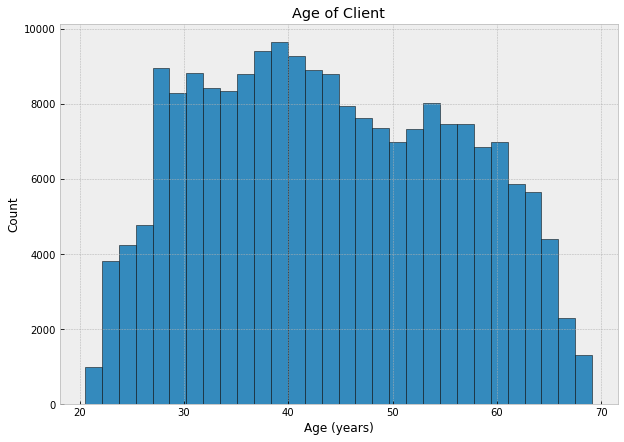

In [27]:
plt.style.use('bmh')
plt.figure(figsize=(10,7))
plt.hist(train['DAYS_BIRTH']/365, edgecolor = 'black', bins=30);
plt.title('Age of Client'); 
plt.xlabel('Age (years)'); 
plt.ylabel('Count');

There is no outliers in ages. To visualize how age and the target are related, we could use KDE(Kernal Density Estimation) plot, which show the distribution of a single value.

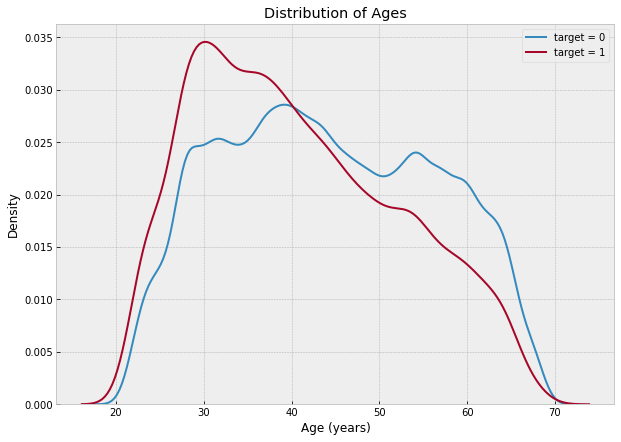

In [28]:
plt.figure(figsize=(10,7))
sns.kdeplot(train['DAYS_BIRTH'][train['TARGET'] == 0]/365, label='target = 0')
sns.kdeplot(train['DAYS_BIRTH'][train['TARGET'] == 1]/365, label='target = 1')
plt.xlabel('Age (years)'); 
plt.ylabel('Density'); 
plt.title('Distribution of Ages');
plt.legend()

The target=1 curve is skewed to the younger ages.

Another way to visualize this relationship is to show the average failure to repay loans by age group.

In [29]:
age_data=train[['TARGET', 'DAYS_BIRTH']]
age_data['YEARS_BIRTH']=train.loc[:,'DAYS_BIRTH']/365
age_data['YEARS_GROUP'] = pd.cut(age_data['YEARS_BIRTH'], bins=np.linspace(20, 70, num = 11))
age_data.groupby('YEARS_GROUP')[['TARGET']].mean()

,TARGET
YEARS_GROUP,
"(20.0, 25.0]",0.124891
"(25.0, 30.0]",0.110064
"(30.0, 35.0]",0.104462
"(35.0, 40.0]",0.089669
"(40.0, 45.0]",0.078310
"(45.0, 50.0]",0.073736
"(50.0, 55.0]",0.066544
"(55.0, 60.0]",0.055598
"(60.0, 65.0]",0.051848


In [30]:
group_age = age_data.groupby('YEARS_GROUP')[['TARGET']].mean()

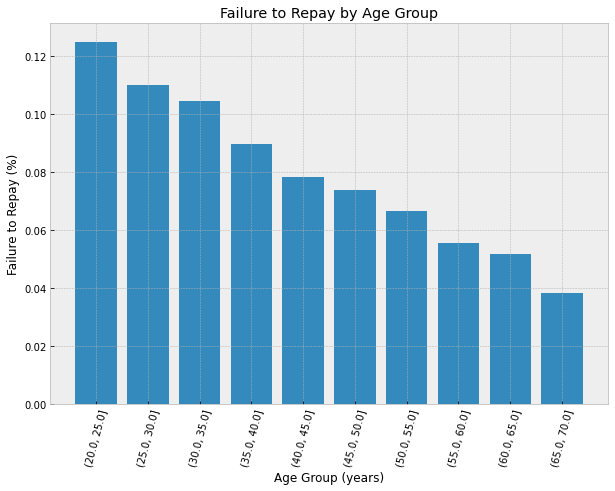

In [31]:
plt.figure(figsize=(10,7))
plt.bar(group_age.index.astype(str), group_age['TARGET'])
plt.xticks(rotation = 75); 
plt.xlabel('Age Group (years)'); 
plt.ylabel('Failure to Repay (%)')
plt.title('Failure to Repay by Age Group');

This clearly shows that older age groups are less likely to not repay.

##### EDA - DAYS EMPLOYED vs TARGET

In [32]:
train['DAYS_EMPLOYED'] = abs(train['DAYS_EMPLOYED'])
train['DAYS_EMPLOYED_ANOM'] = train['DAYS_EMPLOYED'] == 365243
train['DAYS_EMPLOYED'].replace({365243: np.nan}, inplace = True)

test['DAYS_EMPLOYED'] = abs(test['DAYS_EMPLOYED'])
test['DAYS_EMPLOYED_ANOM'] = test['DAYS_EMPLOYED'] == 365243
test['DAYS_EMPLOYED'].replace({365243: np.nan}, inplace = True)

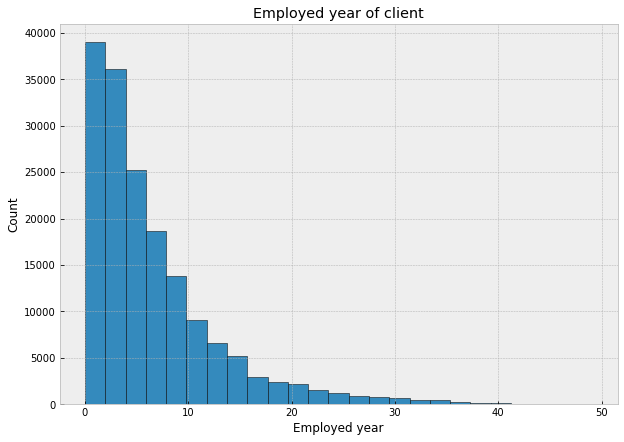

In [33]:
plt.figure(figsize=(10,7))
plt.hist(train['DAYS_EMPLOYED']/365, bins=25, edgecolor='black');
plt.title('Employed year of client')
plt.xlabel('Employed year')
plt.ylabel('Count');

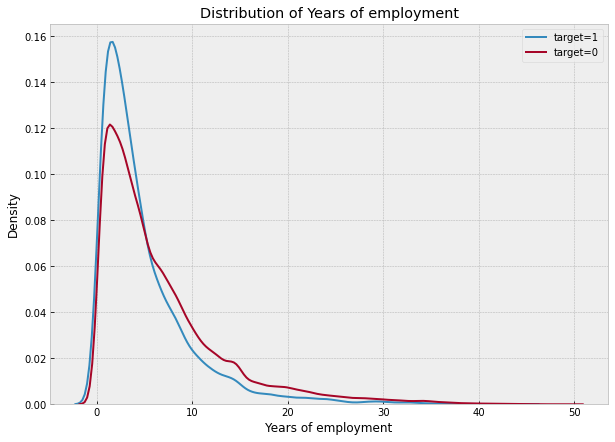

In [34]:
plt.figure(figsize=(10,7))
sns.kdeplot(train['DAYS_EMPLOYED'][train['TARGET'] ==1]/365, label='target=1');
sns.kdeplot(train['DAYS_EMPLOYED'][train['TARGET'] ==0]/365, label='target=0');
plt.xlabel('Years of employment'); 
plt.title('Distribution of Years of employment');
plt.legend()

Both target=1 and target=0 curves are highly left skewed.

##### EDA - EXT_SOURCE_1, EXT_SOURCE_2, EXT_SOURCE_3

EXT_SOURCE_1, EXT_SOURCE_2, EXT_SOURCE_3 are the top 3 features that are showing most negtive correlation with the target.

In [35]:
ext_source = train[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'TARGET']]

In [36]:
ext_source_corr = ext_source.corr()

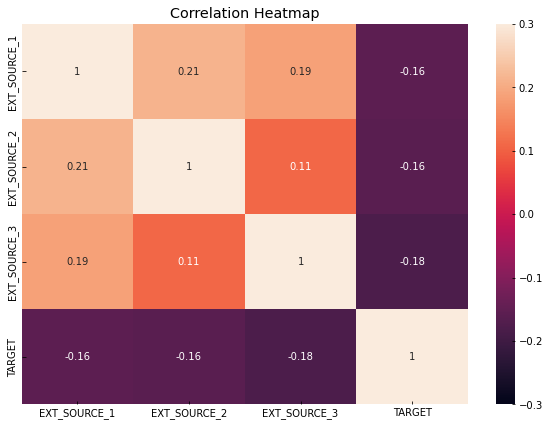

In [37]:
plt.figure(figsize=(10,7))
sns.heatmap(ext_source_corr, annot = True, vmax=0.3, vmin=-0.3)
plt.title('Correlation Heatmap');

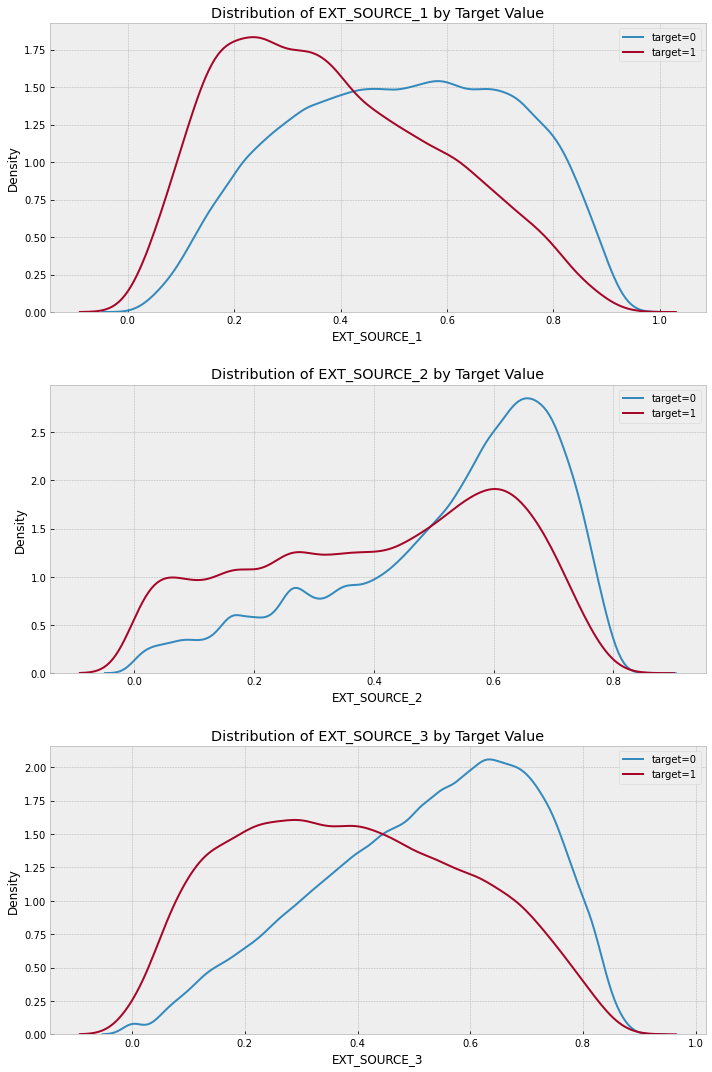

In [38]:
plt.figure(figsize=(10,15))

for i, ext_source in zip (range(3), ['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']):
    
    plt.subplot(3,1,i+1)
    
    sns.kdeplot(train[ext_source][train['TARGET'] == 0], label='target=0')
    sns.kdeplot(train[ext_source][train['TARGET'] == 1], label='target=1')
    
    plt.title('Distribution of {} by Target Value'.format(ext_source))
    plt.legend()
    
plt.tight_layout(h_pad = 2.5)

### Feature Engineering 

#### Polynomial Features 

Polinomial features are powers of existing features and interaction terms between existing features.

While two features by themselves may not have a strong influence on the target, combining them together into a single interaction feature or the power of the features might show a relationship with the target.

In [39]:
# make a new dataframe for polynomial features for both training and test data
poly_features_train = train[[ 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'TARGET']]
poly_features_test = test[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']]

# imputer for handling missing values
imputer = SimpleImputer(strategy = 'median')

poly_target = poly_features_train['TARGET']
poly_features_train = poly_features_train.drop(columns = ['TARGET'])

# need to impute missing values for both training and test data
poly_features_train = imputer.fit_transform(poly_features_train)
poly_features_test = imputer.transform(poly_features_test)

# create the polynomial object with specified degree
poly_transformer = PolynomialFeatures(degree = 3)

# train the polynomial features
poly_transformer.fit(poly_features_train)

# transform the features for both training and test data
poly_features_train = poly_transformer.transform(poly_features_train)
poly_features_test = poly_transformer.transform(poly_features_test)

print('Polynomial Features shape train: ', poly_features_train.shape)
print('Polynomial Features shape test: ', poly_features_test.shape)

Polynomial Features shape train:  (205007, 20)
Polynomial Features shape test:  (102504, 20)


In [40]:
# get the name of new features after polynomial transform
poly_transformer.get_feature_names(input_features = ['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3'])

['1',
 'EXT_SOURCE_1',
 'EXT_SOURCE_2',
 'EXT_SOURCE_3',
 'EXT_SOURCE_1^2',
 'EXT_SOURCE_1 EXT_SOURCE_2',
 'EXT_SOURCE_1 EXT_SOURCE_3',
 'EXT_SOURCE_2^2',
 'EXT_SOURCE_2 EXT_SOURCE_3',
 'EXT_SOURCE_3^2',
 'EXT_SOURCE_1^3',
 'EXT_SOURCE_1^2 EXT_SOURCE_2',
 'EXT_SOURCE_1^2 EXT_SOURCE_3',
 'EXT_SOURCE_1 EXT_SOURCE_2^2',
 'EXT_SOURCE_1 EXT_SOURCE_2 EXT_SOURCE_3',
 'EXT_SOURCE_1 EXT_SOURCE_3^2',
 'EXT_SOURCE_2^3',
 'EXT_SOURCE_2^2 EXT_SOURCE_3',
 'EXT_SOURCE_2 EXT_SOURCE_3^2',
 'EXT_SOURCE_3^3']

In [41]:
# create dataframe of poly features 
poly_features_train = pd.DataFrame(poly_features_train, columns=poly_transformer.get_feature_names(input_features = ['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']))

# add in the target column
poly_features_train['TARGET'] = poly_target

# find the correlation with the target
poly_corr = poly_features_train.corr()['TARGET'].sort_values()

poly_corr

EXT_SOURCE_2 EXT_SOURCE_3                -0.193497
EXT_SOURCE_1 EXT_SOURCE_2 EXT_SOURCE_3   -0.189686
EXT_SOURCE_2^2 EXT_SOURCE_3              -0.176410
EXT_SOURCE_2 EXT_SOURCE_3^2              -0.171967
EXT_SOURCE_1 EXT_SOURCE_2                -0.166706
EXT_SOURCE_1 EXT_SOURCE_3                -0.164954
EXT_SOURCE_2                             -0.159896
EXT_SOURCE_1 EXT_SOURCE_2^2              -0.157444
EXT_SOURCE_3                             -0.156340
EXT_SOURCE_1 EXT_SOURCE_3^2              -0.151454
EXT_SOURCE_2^2                           -0.149895
EXT_SOURCE_3^2                           -0.141987
EXT_SOURCE_2^3                           -0.141066
EXT_SOURCE_1^2 EXT_SOURCE_2              -0.140524
EXT_SOURCE_1^2 EXT_SOURCE_3              -0.139679
EXT_SOURCE_3^3                           -0.128555
EXT_SOURCE_1                             -0.099874
EXT_SOURCE_1^2                           -0.091958
EXT_SOURCE_1^3                           -0.083839
TARGET                         

In [42]:
# put test poly features into dataframe
poly_features_test = pd.DataFrame(poly_features_test, columns=poly_transformer.get_feature_names(input_features = ['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']))

# merge polynomial features into training dataframe
poly_features_train['SK_ID_CURR'] = train['SK_ID_CURR']
train_poly = train.merge(poly_features_train, on = 'SK_ID_CURR', how = 'left')

# merge polynomial features into test dataframe
poly_features_test['SK_ID_CURR'] = test['SK_ID_CURR']
test_poly = test.merge(poly_features_test, on = 'SK_ID_CURR', how = 'left')

# Align the dataframes
train_poly, test_poly = train_poly.align(test_poly, join = 'inner', axis = 1)

print('Training data with polynomial features shape: ', train_poly.shape)
print('Test data with polynomial features shape: ', test_poly.shape)

Training data with polynomial features shape:  (205007, 263)
Test data with polynomial features shape:  (102504, 263)


In [43]:
train_poly['TARGET'] = y_train
print('Training data with polynomial features shape: ', train_poly.shape)
print('Test data with polynomial features shape: ', test_poly.shape)

Training data with polynomial features shape:  (205007, 264)
Test data with polynomial features shape:  (102504, 263)


### Domain knowledge features 

CREDIT_INCOME_PERCENT: the percentage of the credit amount relative to a client's income

ANNUITY_INCOME_PERCENT: the percentage of the loan annuity relative to a client's income

CREDIT_TERM: the length of the payment in months (since the annuity is the monthly amount due

DAYS_EMPLOYED_PERCENT: the percentage of the days employed relative to the client's age

In [44]:
train_domain = train_poly.copy()
test_domain = test_poly.copy()


train_domain['CREDIT_INCOME_PERCENT'] = train_domain['AMT_CREDIT'] / train_domain['AMT_INCOME_TOTAL']
train_domain['ANNUITY_INCOME_PERCENT'] = train_domain['AMT_ANNUITY'] / train_domain['AMT_INCOME_TOTAL']
train_domain['CREDIT_TERM'] = train_domain['AMT_ANNUITY'] / train_domain['AMT_CREDIT']
train_domain['DAYS_EMPLOYED_PERCENT'] = train_domain['DAYS_EMPLOYED'] / train_domain['DAYS_BIRTH']

test_domain['CREDIT_INCOME_PERCENT'] = test_domain['AMT_CREDIT'] / test_domain['AMT_INCOME_TOTAL']
test_domain['ANNUITY_INCOME_PERCENT'] = test_domain['AMT_ANNUITY'] / test_domain['AMT_INCOME_TOTAL']
test_domain['CREDIT_TERM'] = test_domain['AMT_ANNUITY'] / test_domain['AMT_CREDIT']
test_domain['DAYS_EMPLOYED_PERCENT'] = test_domain['DAYS_EMPLOYED'] / test_domain['DAYS_BIRTH']

print('Training data with polynomial features shape: ', train_domain.shape)
print('Test data with polynomial features shape: ', test_domain.shape)

Training data with polynomial features shape:  (205007, 268)
Test data with polynomial features shape:  (102504, 267)


#### Visualize the added new features 

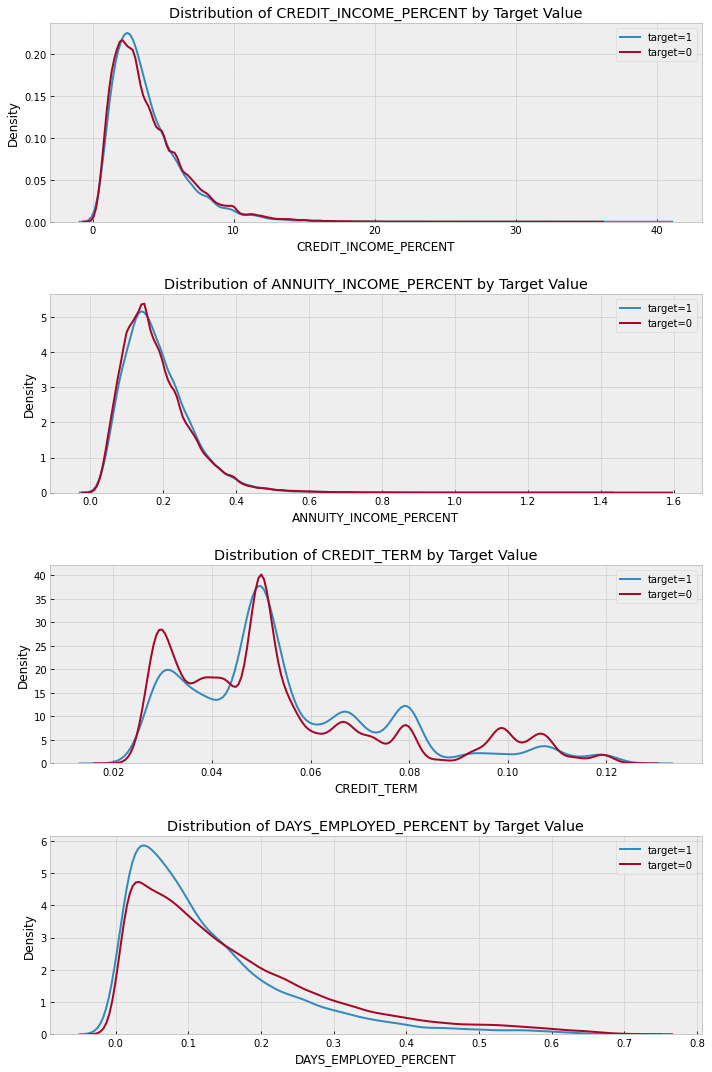

In [45]:
plt.figure(figsize=(10,15))

train['CREDIT_INCOME_PERCENT'] = train['AMT_CREDIT'] / train['AMT_INCOME_TOTAL']
train['ANNUITY_INCOME_PERCENT'] = train['AMT_ANNUITY'] / train['AMT_INCOME_TOTAL']
train['CREDIT_TERM'] = train['AMT_ANNUITY'] / train['AMT_CREDIT']
train['DAYS_EMPLOYED_PERCENT'] = train['DAYS_EMPLOYED'] / train['DAYS_BIRTH']

for i, feature in zip(range(4), ['CREDIT_INCOME_PERCENT', 'ANNUITY_INCOME_PERCENT', 'CREDIT_TERM', 'DAYS_EMPLOYED_PERCENT']):
    plt.subplot(4,1,i+1)
    sns.kdeplot(train[feature][train['TARGET'] ==1], label='target=1')
    sns.kdeplot(train[feature][train['TARGET'] ==0], label='target=0')
    plt.legend()
    plt.title('Distribution of {} by Target Value'.format(feature))
 
plt.tight_layout(h_pad = 2.5)

### Baseline - Logistic Regression 

To get the a baseline, I'll use all the features after encoding. 

In [46]:
X_train = train_domain.copy().drop(columns='TARGET')
X_test = test_domain.copy()

# median imputation of missing values
imputer = SimpleImputer(strategy = 'median')

# fit on the training data
imputer.fit(X_train)

# transform both training and testing data
X_train = imputer.transform(X_train)
X_test = imputer.transform(X_test)

# scale each feature to 0-1
scaler = MinMaxScaler(feature_range = (0, 1))
# fit on the training data
scaler.fit(X_train)
# transform both training and testing data
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)


print('Training data shape: ', X_train.shape)
print('Testing data shape: ', X_test.shape)

Training data shape:  (205007, 267)
Testing data shape:  (102504, 267)


In [47]:
# initialize the model
lg = LogisticRegression()

# train the model
lg.fit(X_train, y_train)

# predict
pred_lg = lg.predict(X_test)
pred_lg_train = lg.predict(X_train)

# use roc auc score to measure the model
auc = roc_auc_score(y_test, pred_lg)
print('Test ROC AUC score: %.3f' % auc)


auc_train = roc_auc_score(y_train, pred_lg_train)
print('Training ROC AUC score: %.3f' % auc_train)

Test ROC AUC score: 0.505
Training ROC AUC score: 0.505


### Improved model: Decision Tree

In [48]:
# initialize the model
dt_default = DecisionTreeClassifier(random_state=42)

# train the model
dt_default.fit(X_train, y_train)

DecisionTreeClassifier(random_state=42)

In [49]:
# predict
pred_dt = dt_default.predict(X_test)
pred_dt_train = dt_default.predict(X_train)

# use roc auc score to measure the model
auc = roc_auc_score(y_test, pred_dt)
prfs = precision_recall_fscore_support(y_test, pred_dt, average='binary')
print('Test ROC AUC score: %.3f' % auc)

auc_train = roc_auc_score(y_train, pred_dt_train)
prfs = precision_recall_fscore_support(y_train, pred_dt_train, average='binary')
print('Training ROC AUC score: %.3f' % auc_train)


Test ROC AUC score: 0.482
Training ROC AUC score: 1.000


The model is apparently overfitting if we compared the score between training and testing data. 

In [50]:
def evaluate_model(dt_classifier):
    print('Test ROC AUC score: {:.3f}'.format(roc_auc_score(y_test, dt_classifier.predict(X_test))))
    print('-'*30)
    print('Training ROC AUC score: {:.3f}'.format(roc_auc_score(y_train, dt_classifier.predict(X_train))))

In [64]:
# Controlling the depth of the tree
dt_depth = DecisionTreeClassifier(max_depth=3,random_state=42)
dt_depth.fit(X_train, y_train)
evaluate_model(dt_depth)

Test ROC AUC score: 0.532
------------------------------
Training ROC AUC score: 0.501


In [54]:
max_depths = np.linspace(1, 30, 15, endpoint=True)
roc_auc_train_results = []
roc_auc_test_results = []
for max_depth in max_depths:
    dt = DecisionTreeClassifier(max_depth=max_depth)
    dt.fit(X_train, y_train)
    
    train_pred = dt.predict(X_train)
    roc_auc_train = roc_auc_score(y_train, train_pred)
    roc_auc_train_results.append(roc_auc_train)
    
    
    test_pred = dt.predict(X_test)
    roc_auc_test = roc_auc_score(y_test, test_pred)
    roc_auc_test_results.append(roc_auc_test)


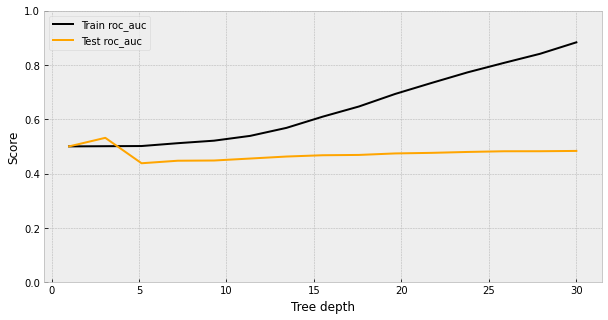

In [55]:
plt.figure(figsize=(10,5))    
plt.plot(max_depths, roc_auc_train_results, 'black', label='Train roc_auc')
plt.plot(max_depths, roc_auc_test_results, 'orange', label='Test roc_auc')

plt.legend()
plt.ylabel('Score')
plt.xlabel('Tree depth')
plt.ylim([0,1])
plt.show()

In [56]:
# specifying minimun samples before split
dt_min_split = DecisionTreeClassifier(min_samples_split=20,random_state=42)
dt_min_split.fit(X_train, y_train)
evaluate_model(dt_min_split)

Test ROC AUC score: 0.482
------------------------------
Training ROC AUC score: 0.790


In [57]:
min_samples_splits = np.linspace(2, 30, 15, endpoint=True, dtype=int)
roc_auc_train_results_split = []
roc_auc_test_results_split = []

for min_samples_split in min_samples_splits:
    dt = DecisionTreeClassifier(min_samples_split=min_samples_split)
    dt.fit(X_train, y_train)
    
    train_pred = dt.predict(X_train)
    roc_auc_train = roc_auc_score(y_train, train_pred)
    roc_auc_train_results_split.append(roc_auc_train)

    
    test_pred = dt.predict(X_test)
    roc_auc_test = roc_auc_score(y_test, test_pred)
    roc_auc_test_results_split.append(roc_auc_test)


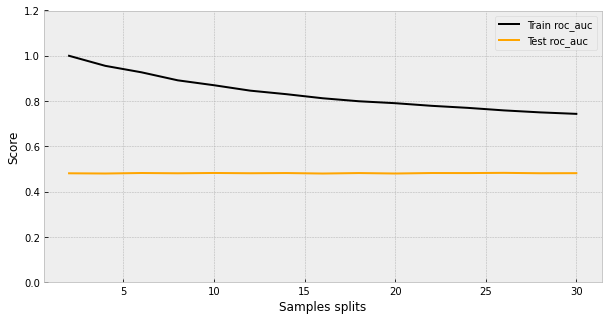

In [59]:
plt.figure(figsize=(10,5))    

plt.plot(min_samples_splits, roc_auc_train_results_split, 'black', label='Train roc_auc')
plt.plot(min_samples_splits, roc_auc_test_results_split, 'orange', label='Test roc_auc')


plt.legend()
plt.ylabel('Score')
plt.xlabel('Samples splits')
plt.ylim([0,1.2])
plt.show()

In [60]:
# specifying minimum samples in leaf node
dt_min_leaf = DecisionTreeClassifier(min_samples_leaf=20, random_state=42)
dt_min_leaf.fit(X_train, y_train)
evaluate_model(dt_min_leaf)

Test ROC AUC score: 0.554
------------------------------
Training ROC AUC score: 0.576


In [61]:
min_samples_leafs = np.linspace(2, 30, 15, endpoint=True, dtype=int)
roc_auc_train_results_leaf = []
roc_auc_test_results_leaf = []

for min_samples_leaf in min_samples_leafs:
    dt = DecisionTreeClassifier(min_samples_leaf=min_samples_leaf)
    dt.fit(X_train, y_train)
    
    train_pred = dt.predict(X_train)
    roc_auc_train = roc_auc_score(y_train, train_pred)
    roc_auc_train_results_leaf.append(roc_auc_train)
    
    test_pred = dt.predict(X_test)
    roc_auc_test = roc_auc_score(y_test, test_pred)
    roc_auc_test_results_leaf.append(roc_auc_test)
    

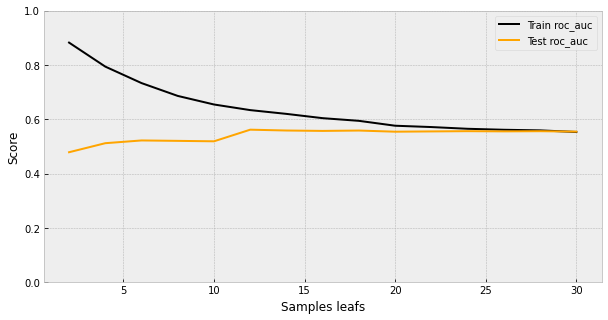

In [62]:
plt.figure(figsize=(10,5))    
plt.plot(min_samples_leafs, roc_auc_train_results_leaf, 'black', label='Train roc_auc')
plt.plot(min_samples_leafs, roc_auc_test_results_leaf, 'orange', label='Test roc_auc')

plt.legend()
plt.ylabel('Score')
plt.xlabel('Samples leafs')
plt.ylim([0,1])
plt.show()

In [63]:
# using entropy instead of gini
dt_min_leaf_entropy = DecisionTreeClassifier(min_samples_leaf=20, random_state=42, criterion="entropy")
dt_min_leaf_entropy.fit(X_train, y_train)
evaluate_model(dt_min_leaf_entropy)

Test ROC AUC score: 0.531
------------------------------
Training ROC AUC score: 0.600


### Decision tree hyperparameter tunning 

In [65]:
dt=DecisionTreeClassifier(random_state=42)

In [81]:
# create the parameter grid based on the results of grid search 
params = {
    'min_samples_leaf': [10, 20, 25],
    'criterion': ["gini", "eAntropy"]
}

In [82]:
# instantiate the grid search model
grid_search = GridSearchCV(estimator=dt, 
                           param_grid=params, 
                           cv=3, n_jobs=-1, verbose=1, scoring = "roc_auc")

In [83]:
grid_search.fit(X_train, y_train)

Fitting 3 folds for each of 6 candidates, totalling 18 fits


GridSearchCV(cv=3, estimator=DecisionTreeClassifier(random_state=42), n_jobs=-1,
             param_grid={'criterion': ['gini', 'eAntropy'],
                         'min_samples_leaf': [10, 20, 25]},
             scoring='roc_auc', verbose=1)

In [84]:
grid_search.best_estimator_

DecisionTreeClassifier(min_samples_leaf=25, random_state=42)

In [85]:
grid_search.best_score_

0.5602371335782018

In [86]:
dt_best=grid_search.best_estimator_
evaluate_model(dt_best)

Test ROC AUC score: 0.555
------------------------------
Training ROC AUC score: 0.562
